# TP1 : Algorithme EM et modèle de mélange gaussien

## Introduction à l'estimation statistique - G3 SDIA

L'objectif de ce TP est d'implémenter l'algorithme EM pour estimer par maximum de vraisemblance les paramètres d'un modèle de mélange gaussien.

On utilisera le dataset *Old Faithful*, qui décrit 272 éruptions du geyser appelé Old Faithful du parc national de Yellowstone aux États-Unis. Chaque observation est constituée de 2 variables : le temps d'attente avant l'éruption (en minutes) et la durée de l'éruption (en minutes).

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 15 Octobre 2023, 23h59.

In [126]:
# Import necessary libraries
import numpy as np
import scipy.stats as ss
import seaborn
from matplotlib import pyplot as plt

**Q1**. Charger le dataset, normaliser puis visualiser les données. Commenter.

In [127]:
import pandas as pd
import io
import requests

# Téléchargez le fichier CSV manuellement depuis le lien Seaborn
url = "https://github.com/mwaskom/seaborn-data/raw/master/geyser.csv"
response = requests.get(url)
data = io.StringIO(response.text)
# Chargez les données à partir du fichier local
df = pd.read_csv(data)

X = df[['duration', 'waiting']].values
N, D = X.shape

# Standardize data to avoid numerical instabilities
standardize = lambda vec : (vec - np.mean(vec))/np.std(vec)
X  = (X - X.mean()) / X.std()

duration = X[:,0]
waiting = X[:,1]
# Show data
plt.scatter(duration, waiting)
plt.show()

ConnectTimeout: HTTPSConnectionPool(host='github.com', port=443): Max retries exceeded with url: /mwaskom/seaborn-data/raw/master/geyser.csv (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x133e05030>, 'Connection to github.com timed out. (connect timeout=None)'))


----- Votre réponse ici -----








**Q2**. On note $\mathbf{x}_1,...,\mathbf{x}_n$ les données. On souhaite les modéliser par un modèle de mélange gaussien à $K$ composantes.

Écrire une fonction permettant de calculer la log-vraisemblance :
$$ \log \mathcal{L}(\theta;\mathbf{x}_1,...,\mathbf{x}_n) = \sum_{i=1}^n \log \left( \sum_{k=1}^K \pi_k \frac{1}{2 \pi \text{det}(\boldsymbol{\Sigma}_k)^{1/2}} \exp \left( \frac{1}{2} (\mathbf{x}_i - \boldsymbol{\mu}_k)^{\top} \boldsymbol{\Sigma}_k^{-1} (\mathbf{x}_i - \boldsymbol{\mu}_k) \right) \right), $$
avec $\theta = \{ \boldsymbol{\mu_1}, ..., \boldsymbol{\mu_k}, \boldsymbol{\Sigma}_1, ..., \boldsymbol{\Sigma}_k, \pi_1, ..., \pi_k \}$.

On pourra utiliser la fonction $\texttt{multivariate} \_ \texttt{normal.pdf}$ de la librairie scipy.stats.

In [ ]:
def log_likelihood(theta, X, K): # Fill in the appropriate arguments
    """
    This function calculates the log_likelihood of an input matrix X.

        params: 
            K: is the number of hyperparameters of our model
            X: is the input matrix
            theta: 
                theta[0] are the K mu vectors
                theta[1] are the K covariance matrix
                theta[2] are the K pi weights of the sum
    """
    total_sum = 0
    for i in range (N):
        intern_sum = 0
        for k in range(K):
            intern_sum += theta[2][k] * ss.multivariate_normal.pdf(X[i,:], mean=theta[0][k], cov=theta[1][k])
        total_sum += np.log(intern_sum)
    
    return total_sum
    # # # # # # # # #
    # YOUR CODE HERE #
    # # # # # # # # #

"""
log_likelihood(
    [
        [[2.1,0.9],[0.9,0.8]],
        [[[1,0],[0,1]],[[1,0],[0,1]]],
        [0.5,0.5]
    ],
    X,
    2
)
"""

'\nlog_likelihood(\n    [\n        [[2.1,0.9],[0.9,0.8]],\n        [[[1,0],[0,1]],[[1,0],[0,1]]],\n        [0.5,0.5]\n    ],\n    X,\n    2\n)\n'

**Q3**. Écrire une fonction qui implémente l'algorithme EM dans ce modèle, prenant pour arguments les données, le nombre de composantes $K$, et le nombre d'itérations de l'algorithme $N_{\text{iter}}$. Cette fonction retournera un tableau de taille $N_{\text{iter}} + 1$ contenant l'évolution des valeurs de la log-vraisemblance, ainsi que les valeurs finales des paramètres.

Initialisation des paramètres :
- Pour les moyennes, les $K$ premières observations du dataset ;
- Pour les matrices de covariances, la matrice identité ;
- $\pi_k = 1/K$.

In [ ]:
from copy import deepcopy

def calculate_log_likelihood(data, means, covariances, pi):
    likelihoods = np.array([ss.multivariate_normal.pdf(data, mean=mean, cov=cov) for mean, cov in zip(means, covariances)])
    weighted_likelihoods = pi * likelihoods.T
    log_likelihood = np.sum(np.log(np.sum(weighted_likelihoods, axis=1)))
    return log_likelihood

def EM_algorithm_v1(X, K, Niter):
        
    # Initialize parameters
    theta = [
        X[:K,:],
        [np.identity(D) for _ in range(K)],
        [1/K for _ in range(K)]
    ]
    """
    output_theta = []
    
    for _ in range(0,Niter):
        # E-STEP
        r_n_k = np.array([[theta[2][k] *  ss.multivariate_normal.pdf(X[l,:], mean=theta[0][k], cov=theta[1][k]) for k in range(K)] for l in range(N)])
        r_n_k = np.array([ r_n_k[l,:] / sum(r_n_k[l,:]) for l in range(N)])
        
        # M-STEP
        for k in range(K):

            theta[0][k] = np.array( np.sum(np.array([ r_n_k[l,k] * X[l,:] for l in range(N) ]), axis=0) / np.sum(r_n_k[:,k]) )
            
            first_term = np.sum(np.array([ r_n_k[l,k] * np.outer(X[l,:],X[l,:]) for l in range(N) ]), axis=0) / np.sum(r_n_k[:,k])
            second_term = np.outer(theta[0][k],theta[0][k])

            theta[1][k] = first_term - second_term

            theta[2][k] = 1/N * np.sum( r_n_k[:,k] )

        output_theta.append(deepcopy(theta))
    
    log_likelihoods = np.array([log_likelihood(theta, X, K) for theta in output_theta])

    return log_likelihoods, theta[0], theta[1], theta[2] # YOUR CODE HERE #
    """
    
    # Store log-likelihood values
    log_likelihoods = []

    for iteration in range(Niter):
        # E-step: Calculate the responsibilities
        responsibilities = []
        for k in range(K):
            likelihood = ss.multivariate_normal.pdf(X, mean=theta[0][k], cov=theta[1][k])
            responsibilities.append(theta[2][k] * likelihood)
        responsibilities = np.array(responsibilities)
        responsibilities /= np.sum(responsibilities, axis=0)
        
        # M-step: Update parameters
        Nk = np.sum(responsibilities, axis=1)
        theta[0] = np.dot(responsibilities, X) / Nk[:, np.newaxis]
        theta[1] = [np.dot(responsibilities[k] * (X - theta[0][k]).T, X - theta[0][k]) / Nk[k] for k in range(K)]
        theta[2] = Nk / len(X)
        
        # Calculate and store the log-likelihood
        log_likelihood_calc = calculate_log_likelihood(X,theta[0], theta[1],theta[2])
        log_likelihoods.append(log_likelihood_calc)
    
    return log_likelihoods, theta[0], theta[1], theta[2]
    


**Q4**. Faire tourner l'algorithme avec $K = 2$ et $N_{\text{iter}} = 50$.

Afficher l'évolution de la log-vraisemblance en fonction des itérations. Commenter.

Sur une même figure, afficher le dataset et représenter les estimations des deux lois normales du mélange à l'aide d'un *contour plot*. On pourra utiliser la fonction $\texttt{plt.contour}$.

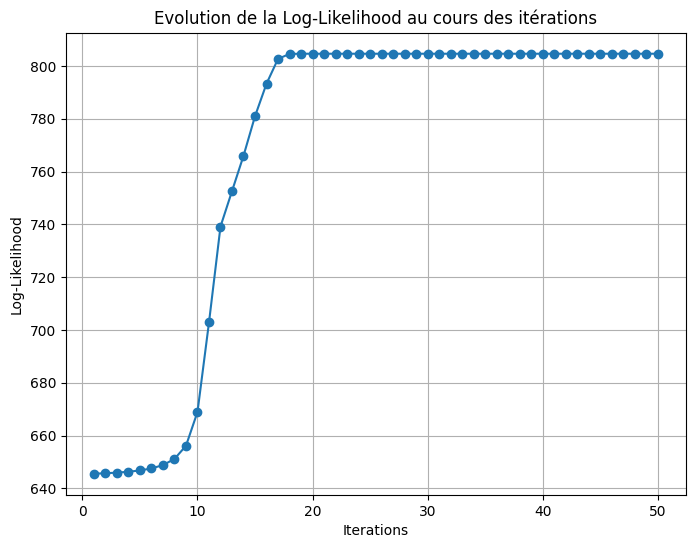

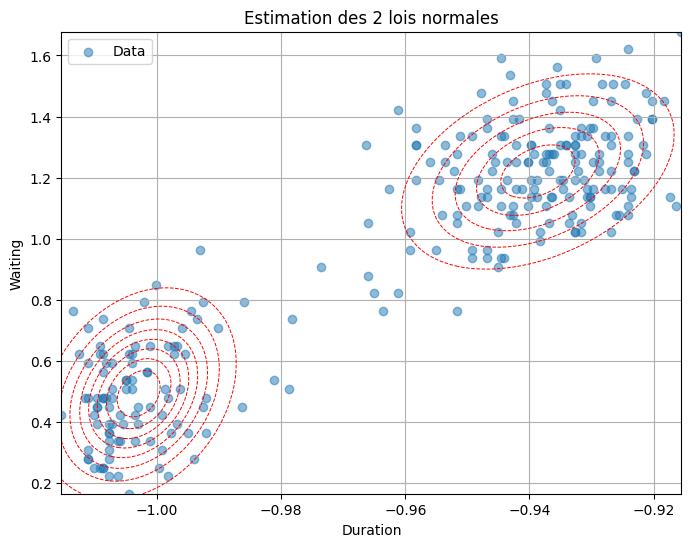

In [ ]:
K = 2
Niter = 50
log_likelihoods, means, variances, pis = EM_algorithm_v1(X, K, Niter)

def plot_log_likelihood(log_likelihoods):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('Log-Likelihood')
    plt.title('Evolution de la Log-Likelihood au cours des itérations')
    plt.grid(True)
    plt.show()

def plot_gaussian_mixture(X, means, covariances):
    plt.figure(figsize=(8, 6))
    
    # Plot the dataset
    plt.scatter(X[:, 0], X[:, 1], alpha=0.5, label='Data')
    
    # Create a grid of values for the contour plot
    x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                       np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
    
    # Evaluate the Gaussian mixture model on the grid
    z = np.zeros_like(x)
    for mean, cov in zip(means, covariances):
        mvn = ss.multivariate_normal(mean=mean, cov=cov)
        z += mvn.pdf(np.dstack((x, y)))

    # Plot the contour lines for the Gaussian mixture
    plt.contour(x, y, z, colors='r', linestyles='dashed', linewidths=0.7, levels=10)
    
    plt.xlabel('Duration')
    plt.ylabel('Waiting')
    plt.title('Estimation des 2 lois normales')
    plt.legend()
    plt.grid(True)
    plt.show

plot_log_likelihood(log_likelihoods)
plot_gaussian_mixture(X, means, variances)

On voit clairement sur le graphique que la log vraisemblance converge en quelques itérations vers une valeur fixe. Pourtant, la valeur calculée pour les log vraisemblance semble très étrange (très élevée) par rapport à ce que j'en avais compris en cours.

----- Votre réponse ici -----

**Q5**. On souhaite maintenant étudier l'influence de l'initialisation sur les résultats. Modifier la fonction implémentant l'algorithme EM en y rajoutant un argument pour la graine aléatoire. Les paramètres seront maintenant initialisés de la manière suivante :
- $\boldsymbol{\mu}_k \sim \mathcal{N}(\mathbf{0},\mathbf{I}_2)$ ;
- $[\pi_1, ..., \pi_K]^{\top} \sim \text{Dirichlet}([1, ..., 1]^{\top})$ ;
- On gardera l'initialisation des matrices de covariance à la matrice identité.

In [ ]:
def EM_algorithm_v2(X, K, Niter, seed):
    N, D = X. shape
    
    # Initialize parameters
    np.random.seed(seed)
    alpha = np.ones(K) #parameter for dirichlet law
    theta = [
        np.array([np.random.normal(0,1,2) for _ in range(K)]),
        [np.identity(D) for _ in range(K)],
        np.random.dirichlet(alpha)
    ]

    # Store log-likelihood values
    log_likelihoods = []

    for iteration in range(Niter):
        # E-step: Calculate the responsibilities
        responsibilities = []
        for k in range(K):
            likelihood = ss.multivariate_normal.pdf(X, mean=theta[0][k], cov=theta[1][k])
            responsibilities.append(theta[2][k] * likelihood)
        responsibilities = np.array(responsibilities)
        responsibilities /= np.sum(responsibilities, axis=0)
        
        # M-step: Update parameters
        Nk = np.sum(responsibilities, axis=1)
        theta[0] = np.dot(responsibilities, X) / Nk[:, np.newaxis]
        theta[1] = [np.dot(responsibilities[k] * (X - theta[0][k]).T, X - theta[0][k]) / Nk[k] for k in range(K)]
        theta[2] = Nk / len(X)
        
        # Calculate and store the log-likelihood
        log_likelihood_calc = calculate_log_likelihood(X,theta[0], theta[1],theta[2])
        log_likelihoods.append(log_likelihood_calc)
    
    return log_likelihoods, theta[0], theta[1], theta[2]

**Q6**. On choisit maintenant $K=3$. Représenter l'évolution de la log-vraisemblance pour 10 graines aléatoires différentes. Commenter.

Afficher deux cas où la solution retournée par l'algorithme EM est visuellement différente. Commenter.

Quelle estimation de paramètres doit-on choisir ?

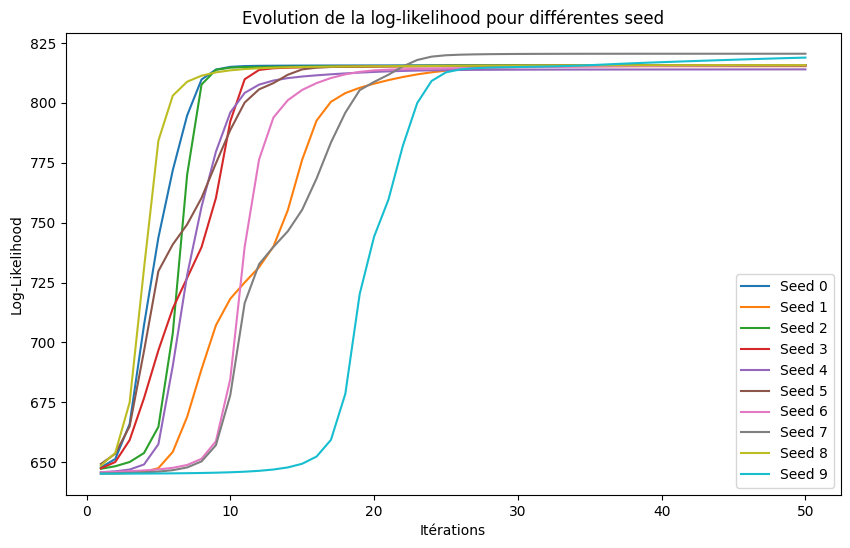

In [134]:
K = 3
random_seeds = range(10)
log_likelihoods_list = []

for seed in random_seeds:
    log_likelihoods, final_means, final_covariances, final_pi = EM_algorithm_v2(X, K, Niter, seed)
    log_likelihoods_list.append(log_likelihoods)

# Plot the log-likelihood evolution for each seed
plt.figure(figsize=(10, 6))
for i, log_likelihoods in enumerate(log_likelihoods_list):
    plt.plot(range(1, len(log_likelihoods) + 1), log_likelihoods, label=f'Seed {random_seeds[i]}')
plt.xlabel('Itérations')
plt.ylabel('Log-Likelihood')
plt.title('Evolution de la log-likelihood pour différentes seed')
plt.legend()
plt.show()



On observe que selon les paramètres initiaux (et donc du choix de la seed), la log vraisemblance ne converge pas toujours vers la même valeur. C'est dû à la nature itérative de l'algorithme EM qui peut s'enfermer dans un minimat/extremat local du champs des solutions possibles.

On cherche à maximiser la log-likelihood, on choisit donc les paramètres finaux déterminés par la seed pour laquelle la log-likelihood finale est la plus élevée : la seed 5 ici en l'occurence.
Attention, la maximisation de la log-likelihood seule ne semble pas suffir pour estimer la viabilité d'un jeu de paramètres (cf graphique seed 9 si dessous). Il faut également comparer les résulats obtenus tracés pour vérifier que visuellement ils correspondent bien aux clusters observables. Ceci est possible ici car nous sommes en 2D, on ne sait pas comment faire si on a plus de 3,4,... dimensions.

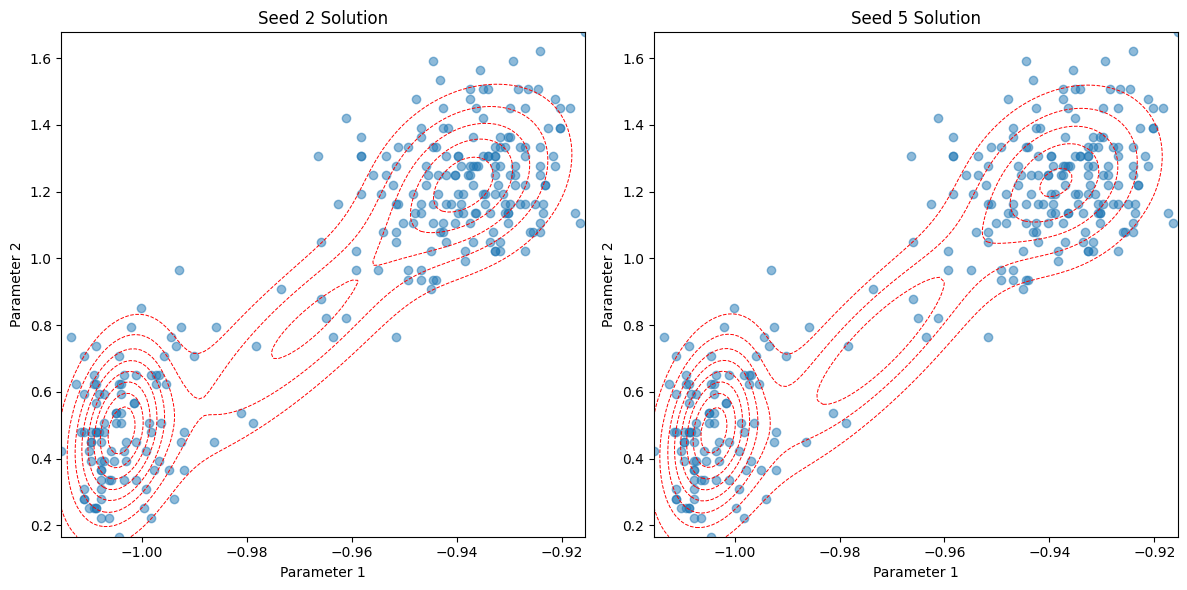

In [144]:
# On choisit la Seed 5 (générant la meilleur log-likelihood) et la Seed 9 (générant un résultat visuellement pas très efficace) 
seed1 = 5
seed2 = 9
log_likelihoods1, final_means1, final_covariances1, final_pi1 = EM_algorithm_v2(X, K, Niter, seed1)
log_likelihoods2, final_means2, final_covariances2, final_pi2 = EM_algorithm_v2(X, K, Niter, seed2)


# Intermediate function to plot on a meshgrid the contour of multivariate normal distribution
def plot_contour(X, final_means, final_covariances):
    # Create a grid of values for the contour plot
    x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                        np.linspace(X[:, 1].min(), X[:, 1].max(), 100))

    # Evaluate the Gaussian mixture model on the grid
    z = np.zeros_like(x)
    for mean, cov in zip(final_means, final_covariances):
        mvn = ss.multivariate_normal(mean=mean, cov=cov)
        z += mvn.pdf(np.dstack((x, y)))
    plt.contour(x, y, z, colors='r', linestyles='dashed', linewidths=0.7, levels=10)

# Plot the dataset and estimated Gaussian mixture components for the two cases
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plot_contour(X,final_means1, final_covariances1)
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title(f'Seed {seed1} Solution')

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plot_contour(X,final_means2, final_covariances2)
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.title(f'Seed {seed2} Solution')

plt.tight_layout()
plt.show()

**Q7**. On cherche maintenant à choisir la valeur optimale de $K$. Pour cela, on aimerait pouvoir comparer la vraisemblance des modèles obtenus avec différentes valeurs de $K$.

Cela peut se faire au travers d'un critère de sélection de modèle. Dans ce TP, nous étudierons le critère dit BIC :
$$ \text{BIC}(m) = k(m) \log(n) - 2 \log \mathcal{L}(m),$$
où $m$ est un modèle (ici donné par une valeur de $K$), $k_m$ est le nombre de paramètres libres dans le modèle, $n$ le nombre d'échantillons, et $\mathcal{L}_m$ le maximum de la fonction de vraisemblance du modèle $m$. On sélectionne le modèle avec le plus faible BIC.

Montrer que $$k(m) = \frac{K}{2} (D+1)(D+2) - 1.$$

Comparer les valeurs de $K$ allant de 1 à 6. Quel est le modèle optimal d'après le critère BIC ?

### Démonstration K(m)

Pour chaque gaussienne, il y a:
* Un vecteur de $D$ moyennes
* Une matrice symetrique de taille $D$, soit $\frac{D(D+1)}{2}$ paramètres libres
* un poids

En sommant ces éléments, on obtient qu'il ya $\frac{1}{2}(D+1)(D+2)$ paramètres libres par gaussienne et donc $\frac{K}{2}(D+1)(D+2)$ paramètres libres au total.

Finalement, comme $\sum{\pi_k} = 1$, la famille $(\pi_1, \ldots, \pi_K)$ est liée et $$k(m) = \frac{1}{2}(D+1)(D+2) - 1$$

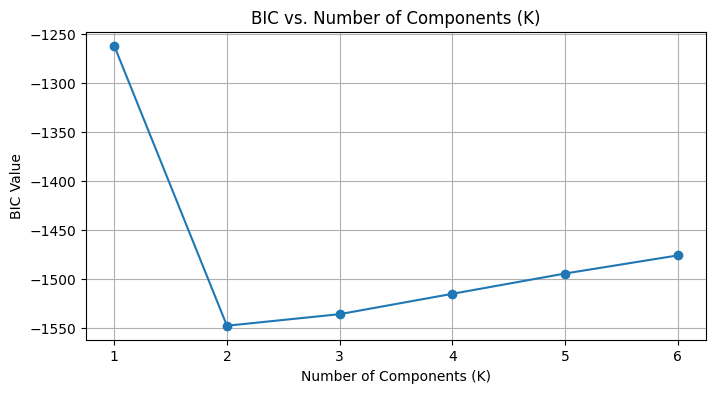

In [146]:
# Define a function to calculate BIC
def calculate_BIC(K, N, D, log_likelihood):
    n = N  # Number of samples
    k = (K/2)*(D+1)*(D+2) - 1  # Number of free parameters in the model
    BIC = k * np.log(n) - 2 * log_likelihood
    return BIC

# We choose the best seed from the question before
random_seed = 5
K_values = range(1, 7)
BIC_values = []

for K in K_values:
    log_likelihoods, final_means, final_covariances, final_pi = EM_algorithm_v2(X, K, Niter, random_seed)
    final_log_likelihood = log_likelihoods[-1]
    BIC = calculate_BIC(K, N, D, final_log_likelihood)
    BIC_values.append(BIC)

plt.figure(figsize=(8, 4))
plt.plot(K_values, BIC_values, marker='o', linestyle='-')
plt.xlabel('Number of parameters K')
plt.ylabel('BIC Value')
plt.title('Evolution of BIC vs. Number of parameters K')
plt.xticks(K_values)
plt.grid(True)
plt.show()

In [148]:
# Find the optimal K (minimum BIC)
optimal_K = K_values[np.argmin(BIC_values)]
print(f"The optimal number of parameters (K) according to minimum BIC criteria is {optimal_K}.")

The optimal number of parameters (K) according to minimum BIC criteria is 2.


**Question bonus**. Expliquer comment l'algorithme EM peut-être utilisé pour du clustering.

Une fois que l'on a fait converger l'algorithme EM (par exemple convergence de la log vraisemblance ou nombre max d'itération) et que l'on a ajusté le nombre adéquate de clusters voulus (par exemple en utilisant le critère BIC) on peut attribuer à n'importe quel point de donnée (correspondant au format du problème) le cluster auquel il est (ou serait) rattaché. Pour cela, on lui attribue le cluster pour lequel sa probabilié d'appartenance est la plus élevée.
